In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from collections import Counter
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import re
import tweepy
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, TFTrainingArguments, BertForSequenceClassification, BertTokenizer 
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from transformers import Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer


In [2]:
# https://www.kaggle.com/datasets/sujaykapadnis/bitcoin-tweets

In [3]:
TRAIN_DIRECTORY = "big-files/tweets.csv"

In [4]:
# Установите свои ключи API
API_KEY = ""
API_KEY_SECRET = ""
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""
BEARER_TOKEN = ""

# 1. Data Exploration and Preprocessing

### 1.1 Loading the Dataset and Understanding its Structure

In [5]:
# # Настройка Tweepy с ключами API
# client = tweepy.Client(
#     bearer_token=BEARER_TOKEN,
#     consumer_key=API_KEY,
#     consumer_secret=API_KEY_SECRET,
#     access_token=ACCESS_TOKEN,
#     access_token_secret=ACCESS_TOKEN_SECRET
# )

In [6]:
# def fetch_tweets(query, count):
#     tweets = tweepy.Paginator(client.search_recent_tweets, 
#                                        query=query,
#                                        tweet_fields=["created_at", "text"],
#                                        max_results=100
#                                        ).flatten(limit=count)
#     tweets_list = [[tweet.created_at, tweet.text] for tweet in tweets]
#     return pd.DataFrame(tweets_list, columns=["timestamp", "text"])

# # Сбор данных
# df = fetch_tweets("#Bitcoin", 10)
# df.to_csv("big-files/crypto_tweets.csv", index=False)

In [7]:
# tweets = pd.read_csv("big-files/crypto_tweets.csv")
# tweets

In [8]:
# Load the data
df = pd.read_csv(TRAIN_DIRECTORY)
df

,token,date,reply_count,like_count,retweet_count,quote_count,text,sentiment_label,sentiment_score
0,bitcoin,2022-01-01 00:00:00.000,20,207,31,3,Most people underestimate the impact #Bitcoin ...,Neutral,0.717482
1,bitcoin,2022-01-01 00:00:00.000,232,3405,286,27,#Bitcoin has started a new yearly candle https...,Neutral,0.810814
2,bitcoin,2022-01-01 00:00:00.000,2,861,12,0,@DESTROYBINARY did people forget that the amog...,Neutral,0.606978
3,bitcoin,2022-01-01 00:00:00.000,18,306,30,9,"In 2017, miners attempted to assert control ov...",Negative,0.510956
4,bitcoin,2022-01-01 00:00:00.000,35,721,35,1,Yearly Close \nMonthly Close\nDaily Close\n\nh...,Positive,0.988296
...,...,...,...,...,...,...,...,...,...
76792,bitcoin,2023-06-22 00:00:00.000,8,204,35,2,IMF says while a few countries have banned #Bi...,Negative,0.615765
76793,bitcoin,2023-06-22 00:00:00.000,8,298,17,4,"Fear, Greed &amp; Bitcoin | #SheCrypto https:/...",Neutral,0.687251
76794,bitcoin,2023-06-22 00:00:00.000,17,86,17,0,I know I may be unpopular for saying this but ...,Neutral,0.532809
76795,bitcoin,2023-06-22 00:00:00.000,193,3048,771,42,#Bitcoin now has the support of presidential c...,Positive,0.935171


In [9]:
# We see information about the dimension of our dataframe
df.shape 

(76797, 9)

In [10]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76797 entries, 0 to 76796
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   token            76797 non-null  object 
 1   date             76797 non-null  object 
 2   reply_count      76797 non-null  int64  
 3   like_count       76797 non-null  int64  
 4   retweet_count    76797 non-null  int64  
 5   quote_count      76797 non-null  int64  
 6   text             76797 non-null  object 
 7   sentiment_label  76797 non-null  object 
 8   sentiment_score  76797 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 5.3+ MB


In [11]:
# The number of unique values for each column
df.nunique() 

token                  1
date                 538
reply_count         1821
like_count          7323
retweet_count       2690
quote_count          584
text               75955
sentiment_label        3
sentiment_score    75530
dtype: int64

The data is well-structured and complete, with no missing values. This ensures that it’s ready for analysis without needing extensive preprocessing, allowing for accurate insights into user behavior and sentiment around Bitcoin.

### 1.2. Perform basic exploratory data analysis (EDA) to understand the distribution

In [12]:
# Check for missing values
df.isnull().sum()

token              0
date               0
reply_count        0
like_count         0
retweet_count      0
quote_count        0
text               0
sentiment_label    0
sentiment_score    0
dtype: int64

In [13]:
# Check for duplicates and non-dublicates
df.duplicated().value_counts()

False    76734
True        63
Name: count, dtype: int64

In [14]:
# Remove duplicates
df = df.drop_duplicates()

In [15]:
# Sentiment describe
df["sentiment_score"].describe()

count    76734.000000
mean         0.713478
std          0.141160
min          0.340653
25%          0.592395
50%          0.710428
75%          0.833892
max          0.993558
Name: sentiment_score, dtype: float64

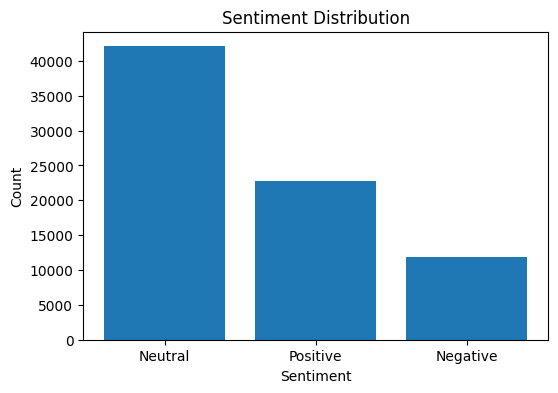

In [16]:
# Visualization of sentiments
sentiment_counts = df['sentiment_label'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [17]:
# Clean text function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags 
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove non-ASCII characters
    text = re.sub(r"[^A-Za-z0-9\s]+", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text)  # Replace multiple whitespace characters with a single space
    text = text.lower()  # Convert text to lowercase
    return text


In [18]:
# Get cleaned text
df.loc[:, "clean_text"] = df["text"].apply(clean_text)

C:\Users\ivanz\AppData\Local\Temp\ipykernel_21816\1719401625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "clean_text"] = df["text"].apply(clean_text)


In [19]:
# Join all in one for using
all_text = ' '.join(df["clean_text"])

In [20]:
# Adding custom stopwords (the, is, a...)
custom_stopwords = set(STOPWORDS)
# custom_stopwords.add('word')

# Creating the word cloud while excluding stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords, max_words=100).generate(all_text)

In [21]:
# Extract frequencies from the word cloud
word_frequencies = wordcloud.process_text(all_text) 
word_freq_counter = Counter(word_frequencies)   # sort and display word frequencies

for word, freq in word_freq_counter.most_common(20): # Display 20 words
    print(f"{word}: {freq}")

bitcoin: 17418
will: 5908
btc: 5120
now: 3729
amp: 3633
new: 3599
crypto: 3213
people: 3039
time: 2844
one: 2839
buy: 2692
money: 2308
today: 2203
world: 2203
year: 2152
price: 2045
day: 2009
u: 1866
see: 1838
going: 1833


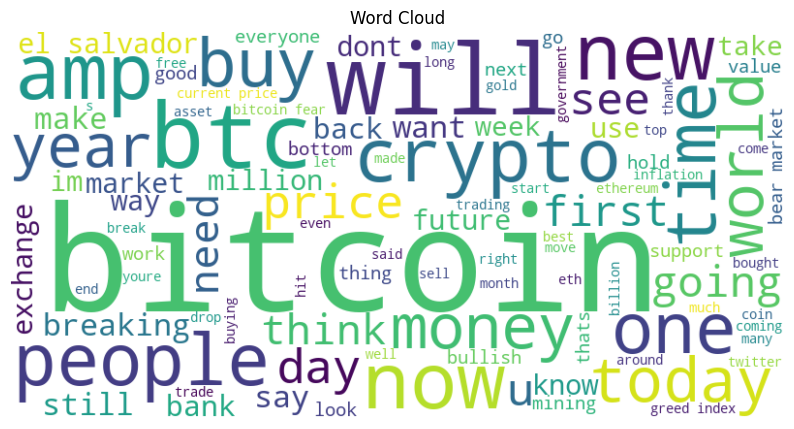

In [22]:
# Displaying the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud")
plt.show()

Conclusion:
Terms like "bitcoin," "btc," and "crypto" highlight the central theme, while words such as "will," "now," and "new" suggest a focus on upcoming events and recent developments. The presence of terms like "buy," "price," and "money" indicates that the conversations frequently touch on financial matters and market dynamics.

In [23]:
# Converting a date to a normal format
df["date"] = pd.to_datetime(df["date"], errors="coerce")
# Lets make sure that the conversion was successful
df["date"].head(3)

C:\Users\ivanz\AppData\Local\Temp\ipykernel_21816\2938940306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"], errors="coerce")


0   2022-01-01
1   2022-01-01
2   2022-01-01
Name: date, dtype: datetime64[ns]

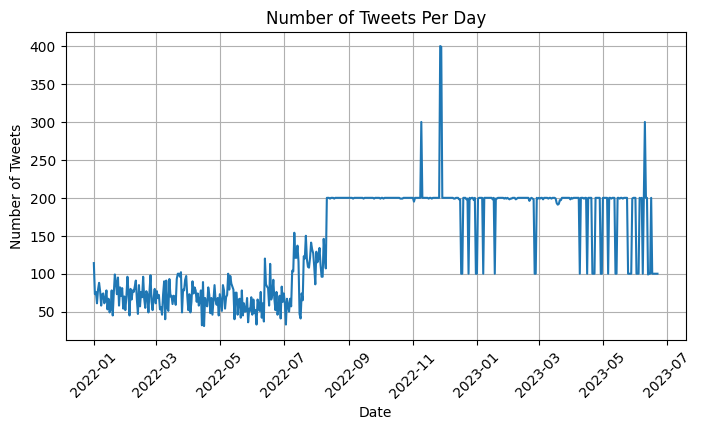

In [24]:
# Number of tweets per day
tweets_per_day = df.groupby(df['date'].dt.date).size()

plt.figure(figsize=(8, 4))
plt.plot(tweets_per_day.index, tweets_per_day.values)
plt.title("Number of Tweets Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

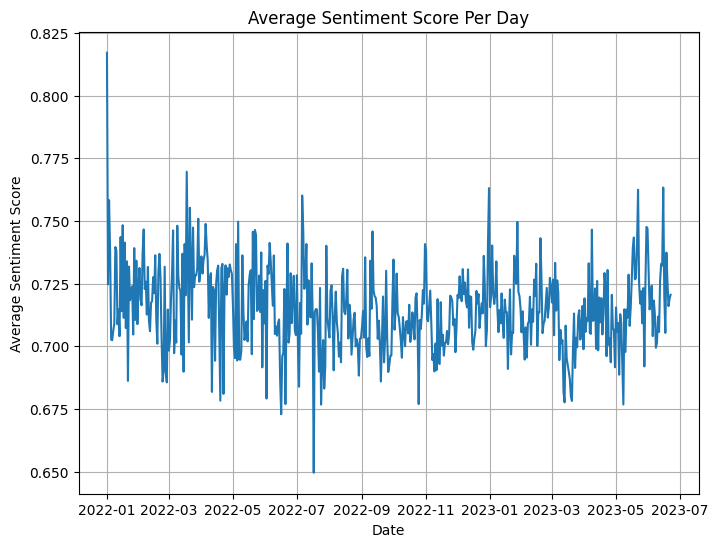

In [25]:
# Plot average sentiment score per day
average_sentiment_per_day = df.groupby(df['date'].dt.date)['sentiment_score'].mean()

plt.figure(figsize=(8, 6))
average_sentiment_per_day.plot()
plt.title('Average Sentiment Score Per Day')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

Conclusion: 
- The data on tweet counts shows that activity varies daily. 
- Periods with a high number of tweets do not always coincide with periods when the average sentiment was higher or lower. This suggests that tweet activity does not always directly affect the overall sentiment on social media. - A sharp increase or decrease in tweet counts may correspond with specific events that influence the overall sentiment.

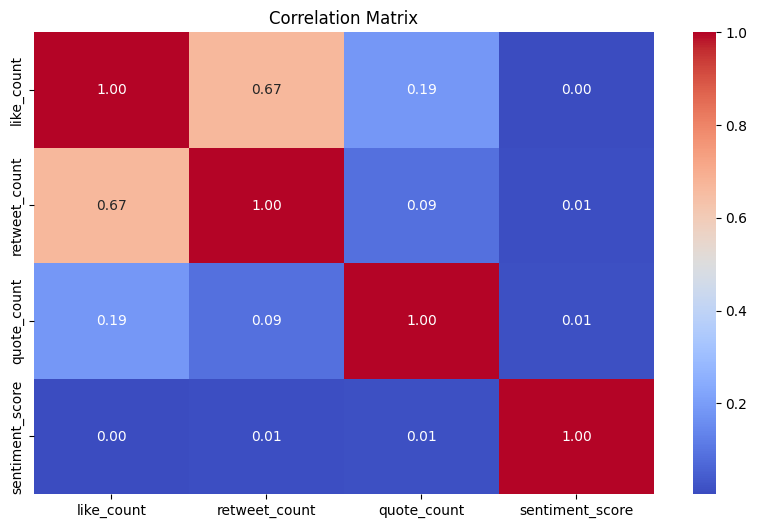

In [26]:
# Correlation matrix
correlation_matrix = df[["like_count", "retweet_count", "quote_count", "sentiment_score"]].corr()

# Building a heat map
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Conclusion:
- There is a moderate correlation between likes and retweets, indicating that tweets with more likes tend to also have more retweets. However, there is little to no relationship between these metrics and the tweet’s sentiment or the number of times the tweet is quoted.
- Retweets and quotes have a very weak relationship with each other.
- Sentiment is almost independent of likes, retweets, and quotes.

These results suggest that tweet engagement metrics (likes, retweets, and quotes) are generally not strongly related to each other or to the sentiment of the tweets.

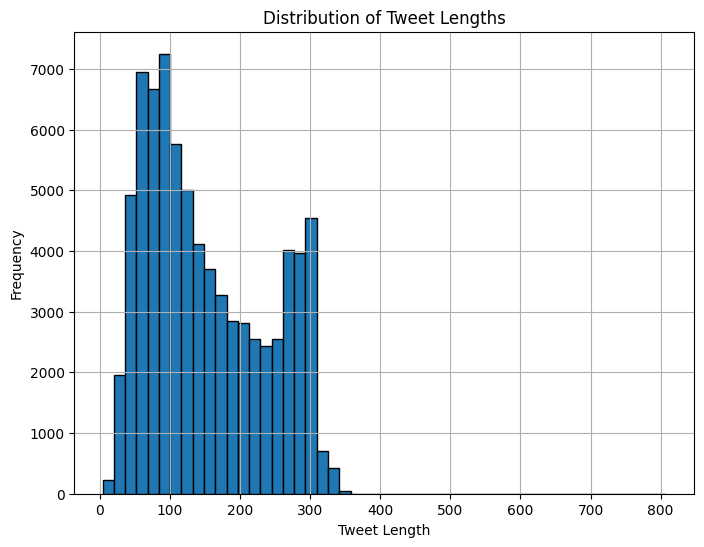

In [27]:
# Tweet length
plt.figure(figsize=(8, 6))
plt.hist(df['text'].apply(len), bins=50, edgecolor='black')
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

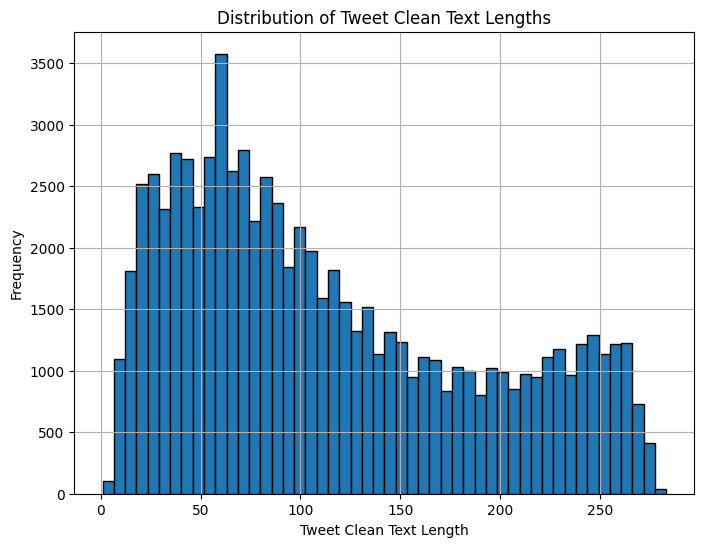

In [28]:
# Tweet length clean text
plt.figure(figsize=(8, 6))
plt.hist(df['clean_text'].apply(len), bins=50, edgecolor='black')
plt.title("Distribution of Tweet Clean Text Lengths")
plt.xlabel("Tweet Clean Text Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Conclusion:
- The cleaning process affected the length of tweets. The lengths of the cleaned tweets still vary widely, indicating that the cleaning did not significantly alter the distribution of tweet lengths.

# 2. Data Preprocessing and Tokenization

### 2.1 Tokenize the text data using a pre-trained tokenizer from a transformer model

In [29]:
df

,token,date,reply_count,like_count,retweet_count,quote_count,text,sentiment_label,sentiment_score,clean_text
0,bitcoin,2022-01-01,20,207,31,3,Most people underestimate the impact #Bitcoin ...,Neutral,0.717482,most people underestimate the impact will have...
1,bitcoin,2022-01-01,232,3405,286,27,#Bitcoin has started a new yearly candle https...,Neutral,0.810814,has started a new yearly candle
2,bitcoin,2022-01-01,2,861,12,0,@DESTROYBINARY did people forget that the amog...,Neutral,0.606978,did people forget that the amogus meme was an...
3,bitcoin,2022-01-01,18,306,30,9,"In 2017, miners attempted to assert control ov...",Negative,0.510956,in 2017 miners attempted to assert control ove...
4,bitcoin,2022-01-01,35,721,35,1,Yearly Close \nMonthly Close\nDaily Close\n\nh...,Positive,0.988296,yearly close monthly close daily close have al...
...,...,...,...,...,...,...,...,...,...,...
76792,bitcoin,2023-06-22,8,204,35,2,IMF says while a few countries have banned #Bi...,Negative,0.615765,imf says while a few countries have banned tha...
76793,bitcoin,2023-06-22,8,298,17,4,"Fear, Greed &amp; Bitcoin | #SheCrypto https:/...",Neutral,0.687251,fear greed amp bitcoin
76794,bitcoin,2023-06-22,17,86,17,0,I know I may be unpopular for saying this but ...,Neutral,0.532809,i know i may be unpopular for saying this but ...
76795,bitcoin,2023-06-22,193,3048,771,42,#Bitcoin now has the support of presidential c...,Positive,0.935171,now has the support of presidential candidate...


Вы используете AutoTokenizer для токенизации текста, используя модель RoBERTa, специально настроенную для Twitter.
Токенизация включает в себя обрезку и паддинг до заданной длины, что позволяет подготовить данные для модели.

In [30]:
# Load the tokenizer for the twitter-roberta-base-sentiment-latest model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
# Создание модели
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", num_labels=3)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
# Apply tokenization to the texts
tokenized_data = tokenizer(df["clean_text"].tolist(),    # tweets
                   max_length = 64,        # Maximum length of tokenized text (128 tokens)
                   padding = "max_length",      # Adding padding (additional tokens) until max_length is reached
                   truncation = True,      # Cropping the text if it is longer than max_length
                   return_tensors = "np",   # Returned NumPy tensors
                   return_attention_mask = True,       # Attention mask
                   )


input_ids = tokenized_data["input_ids"]         # numeric representations of tokens
attention_masks = tokenized_data["attention_mask"]      # attention mask

Conclusion: This code prepares data for sentiment analysis using the RoBERTa model adapted for Twitter. It provides correct text processing (including padding and cropping), data conversion to a TensorFlow-compatible format, and includes attention masks to improve model performance. This makes it possible to effectively use the model to analyze sentiment based on tweets.

### 2.2 Prepare the tokenized data for input into the model

Преобразование меток настроений в числовые значения с использованием LabelEncoder.
to_categorical используется для преобразования меток в формат one-hot encoding.

In [33]:
# Преобразование настроений в числовые метки
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment_label"])
label = to_categorical(df["label"])

C:\Users\ivanz\AppData\Local\Temp\ipykernel_21816\4272445055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = label_encoder.fit_transform(df["sentiment_label"])


Вы делите данные на обучающие, валидационные и тестовые наборы с использованием train_test_split.

Проверьте, что input_ids, attention_masks, и label находятся в формате numpy или list перед созданием Dataset.

Для того чтобы исправить код, чтобы он корректно работал с PyTorch и библиотекой datasets, нам нужно будет сначала преобразовать ваши данные в формат Dataset, а затем использовать методы из datasets для разделения на обучающие, валидационные и тестовые наборы.

In [34]:
# Преобразование меток в формат `Dataset`
def create_dataset(input_ids, attention_masks, labels):
    return Dataset.from_dict({
        'input_ids': list(input_ids),
        'attention_mask': list(attention_masks),
        'labels': list(labels)
    })

# Создание полного Dataset
dataset = create_dataset(input_ids, attention_masks, label)

In [35]:
# Разделение данных
dataset_split = dataset.train_test_split(test_size=0.4, seed=42)
test_valid_split = dataset_split['test'].train_test_split(test_size=0.5, seed=42)

# Создание DatasetDict
datasets = DatasetDict({
    'train': dataset_split['train'],
    'validation': test_valid_split['train'],
    'test': test_valid_split['test']
})

не исспользуйте One-Drive папку. Возникает ошибка при создании results и logs

In [ ]:
# Настройка параметров обучения
training_args = TrainingArguments(
    output_dir="./results",                        # Директория для результатов
    num_train_epochs=3,                            # Количество эпох
    learning_rate=2e-5,                            # Скорость обучения
    per_device_train_batch_size=32,                # Размер батча для тренировки (увеличен)
    per_device_eval_batch_size=32,                 # Размер батча для валидации (увеличен)
    warmup_steps=500,                              # Количество шагов для прогрева
    weight_decay=0.01,                             # Вес для декей
    logging_dir="./logs",                          # Директория для логов
    logging_steps=10,                              # Частота логирования
    eval_strategy="epoch",                   # Стратегия оценки
    fp16=True,                                     # Включаем mixed precision для ускорения
    gradient_accumulation_steps=2,                 # Увеличение виртуального размера батча
    dataloader_num_workers=4,                      # Увеличение числа воркеров для загрузки данных
    report_to="none",                              # Отключаем WandB и другие репортеры для простоты
)

c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
# Инициализация тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['validation'],
    tokenizer=tokenizer
)

In [38]:
# Обучение модели
trainer.train()

  0%|          | 0/8634 [00:00<?, ?it/s]

{'loss': 0.4764, 'grad_norm': 6.42495059967041, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.0}
{'loss': 0.4537, 'grad_norm': 6.153571128845215, 'learning_rate': 8.000000000000001e-07, 'epoch': 0.01}
{'loss': 0.4533, 'grad_norm': 5.012454986572266, 'learning_rate': 1.2000000000000002e-06, 'epoch': 0.01}
{'loss': 0.4639, 'grad_norm': 4.57293701171875, 'learning_rate': 1.6000000000000001e-06, 'epoch': 0.01}
{'loss': 0.4371, 'grad_norm': 7.994412899017334, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 0.4066, 'grad_norm': 5.0929107666015625, 'learning_rate': 2.4000000000000003e-06, 'epoch': 0.02}
{'loss': 0.3673, 'grad_norm': 4.4963908195495605, 'learning_rate': 2.8000000000000003e-06, 'epoch': 0.02}
{'loss': 0.3901, 'grad_norm': 4.793356895446777, 'learning_rate': 3.2000000000000003e-06, 'epoch': 0.03}
{'loss': 0.3538, 'grad_norm': 7.916404724121094, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.03}
{'loss': 0.3659, 'grad_norm': 7.255688190460205, 'learnin

KeyboardInterrupt: 

In [ ]:
# Оценка модели на тестовом наборе данных
trainer.evaluate(datasets['test'])